In [1]:
from cpymad.madx import Madx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from pybt.tools.plotters import *
from matplotlib.patches import Ellipse, Rectangle
import requests
import sys
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from ezdxf import recover
from ezdxf.addons.drawing import RenderContext, Frontend
from ezdxf.addons.drawing.matplotlib import MatplotlibBackend

from t12_functions import *

# GEODE

In [14]:
import warnings
# Suppress FutureWarnings and RuntimeWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

### GEODE ###

# Loading data
dev_f61 = pd.read_csv('geode_data/beam_dev_18_11_2021_F61.csv', skiprows=1)
dev_pr = pd.read_csv('geode_data/beam_dev_18_11_2021_PR.csv', skiprows=1)
dev_t08 = pd.read_csv('geode_data/beam_dev_18_11_2021_T08.csv', skiprows=1)
dev_t09 = pd.read_csv('geode_data/beam_dev_18_11_2021_T09.csv', skiprows=1)
dev_t10 = pd.read_csv('geode_data/beam_dev_18_11_2021_T10.csv', skiprows=1)
dev_t11 = pd.read_csv('geode_data/beam_dev_18_11_2021_T11.csv', skiprows=1)
dev_f62 = pd.read_csv('geode_data/beam_dev_18_11_2021_F62.csv', skiprows=1)
dev_f63 = pd.read_csv('geode_data/beam_dev_18_11_2021_F63.csv', skiprows=1)

df_f61 = calc_absolute_deviation(dev_f61)
df_pr = calc_absolute_deviation(dev_pr)
df_t08 = calc_absolute_deviation(dev_t08)
df_t09 = calc_absolute_deviation(dev_t09)
df_t10 = calc_absolute_deviation(dev_t10)
df_t11 = calc_absolute_deviation(dev_t11)
df_f62 = calc_absolute_deviation(dev_f62)
df_f63 = calc_absolute_deviation(dev_f63)

# Rotation parameters for GEODE
angle_degrees = 7.8
center_of_rotation = (2000, 2100)  # Example center (cx, cy)

for df in [df_f61, df_pr, df_t08, df_t09, df_t10, df_t11, df_f62, df_f63]:
    # Apply rotation to specific row
    for i in df.index:
        x_rotated, y_rotated = rotate_around_point(df.loc[i, 'x'], df.loc[i, 'y'], *center_of_rotation, angle_degrees)
        df.loc[i, 'x'] = x_rotated
        df.loc[i, 'y'] = y_rotated

# MAD-X

In [4]:
E_cin_per_nucleon = 2.0
# Ion properties
A = 208.0
Z = 82.0
N = 126.0
charge = 54.0
m_proton_GeV = 0.93828
m_neutron_GeV = 0.93957
m_electron_GeV = 0.000511
m_u_GeV = 0.9315
mass_defect_GeV = Z * m_proton_GeV + N * m_neutron_GeV + (Z - charge) * m_electron_GeV - A * m_u_GeV
E_0 = Z * m_proton_GeV + N * m_neutron_GeV - mass_defect_GeV

p = E_0 * np.sqrt((((E_cin_per_nucleon * A) / E_0) + 1) ** 2 - 1)

gamma = p/charge/0.938
beta = np.sqrt(1-gamma**(-2))

print(p/charge)
print(f"gamma = {round(gamma,3)}")
print(f"beta = {round(beta,3)}")
print(f"p = {round(p/charge,3)} GeV/c")

Brho = 3.33564*p/charge

# Beam characteristics
exn = 4.92e-06
eyn = 3.4e-06
sige = 0.000412
ex = exn/(beta*gamma)
ey = eyn/(beta*gamma)

# Initial conditions
betx0 = 53.074
bety0 = 3.675
alfx0 = -13.191
alfy0 = 0.859
Dx0 = 0.13
Dy0 = 0.0
Dpx0 = 0.02
Dpy0 = 0.0
exn = 2.53e-05
eyn =  6.94e-06
sige = 0.00045

10.706294697042374
gamma = 11.414
beta = 0.996
p = 10.706 GeV/c


In [5]:
survey_f61d = f61d(p, exn, eyn, betx0, bety0, alfx0, alfy0, Dx0, Dy0, Dpx0, Dpy0)
survey_f61t8 = t8(p, exn, eyn, betx0, bety0, alfx0, alfy0, Dx0, Dy0, Dpx0, Dpy0)
survey_f61t12 = t12(p, exn, eyn, betx0, bety0, alfx0, alfy0, Dx0, Dy0, Dpx0, Dpy0)

# Translate and rotate the MAD-X surveys
df_survey_f61d_translated = translate_rotate(survey_f61d)
df_survey_f61t8_translated = translate_rotate(survey_f61t8)
df_survey_f61t12_translated = translate_rotate(survey_f61t12)

# Combine into single image

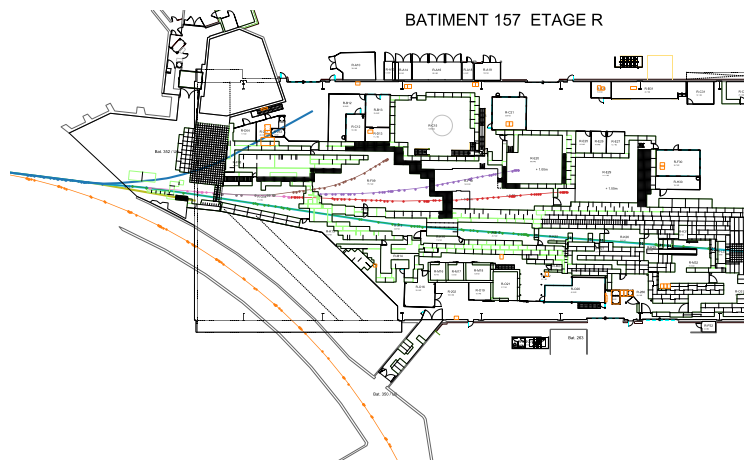

In [6]:
x_change_ref = 75490
y_change_ref = 9309.75

fig, ax = plt.subplots(figsize=(50,10), tight_layout=True)
doc, auditor = recover.readfile('157_R.dxf')
ctx = RenderContext(doc)
out = MatplotlibBackend(ax)

from ezdxf.addons.drawing.config import Configuration, BackgroundPolicy
config = Configuration().with_changes(background_policy=BackgroundPolicy.CUSTOM, custom_bg_color="#ffffff00", lineweight_scaling=1)

frontend = Frontend(ctx, out, config=config)
frontend.draw_layout(doc.modelspace(), finalize=True)


# Plot GEODE
for df in [df_f61, df_pr, df_t08, df_t09, df_t10, df_t11, df_f62, df_f63]:
    ax.plot(x_change_ref + df.x, y_change_ref + df.y, marker="+",zorder=99, markersize=2, linewidth=0.5)

# Plot the MAD-X survey
for df in [df_survey_f61d_translated, df_survey_f61t8_translated, df_survey_f61t12_translated]:
    ax.plot(df.x_rot, df.y_rot)

xmin = 77510
xmax = 77640
ymin = 11490
ymax = 11500

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

ax.set_aspect("equal")
fig.savefig('East_Area_combined_survey.png', dpi=800)

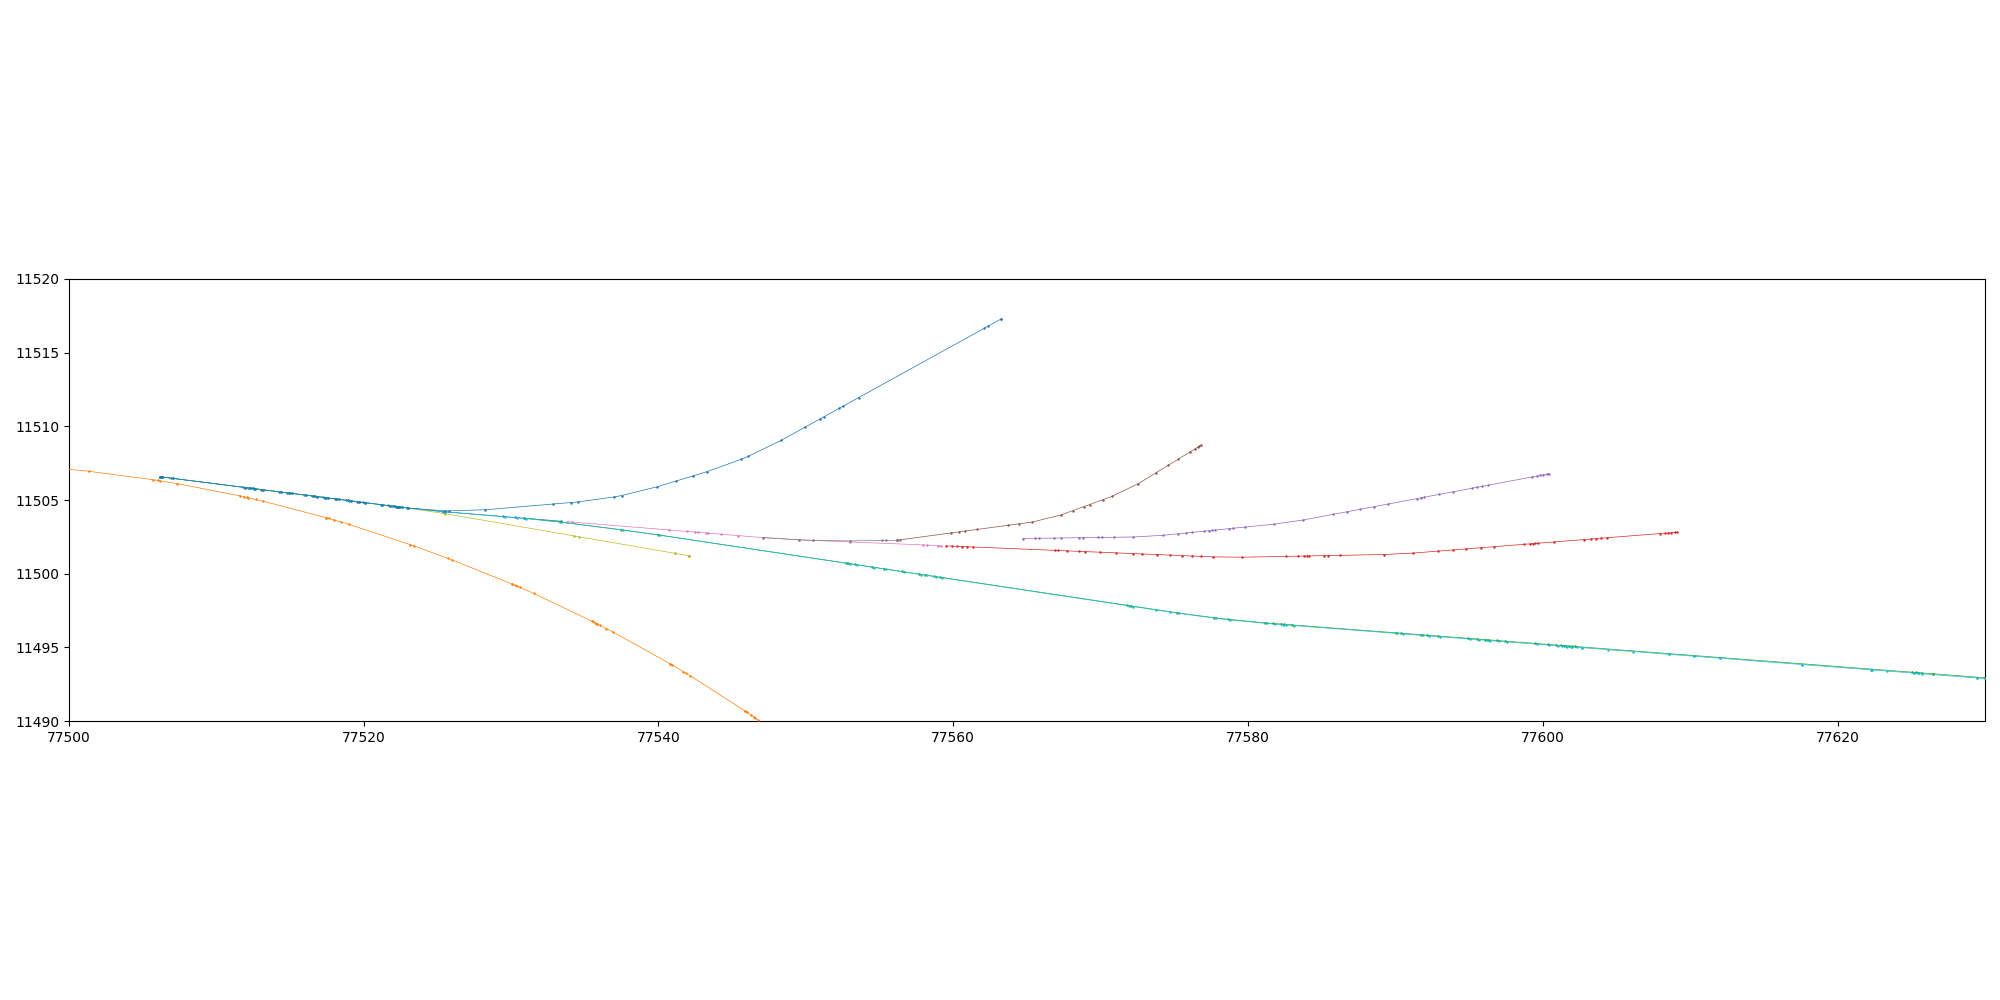

In [7]:
%matplotlib widget
fig, ax = plt.subplots(figsize=(20,10), tight_layout=True)

for df in [df_f61, df_pr, df_t08, df_t09, df_t10, df_t11, df_f62, df_f63]:
    ax.plot(x_change_ref + df.x, y_change_ref + df.y, marker="+",zorder=99, markersize=2, linewidth=0.5)

for df in [df_survey_f61d_translated, df_survey_f61t8_translated, df_survey_f61t12_translated]:
    ax.plot(df.x_rot, df.y_rot, marker="+",zorder=99, markersize=2, linewidth=0.5)

xmin = 77500
xmax = 77630
ymin = 11490
ymax = 11520

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_aspect("equal")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


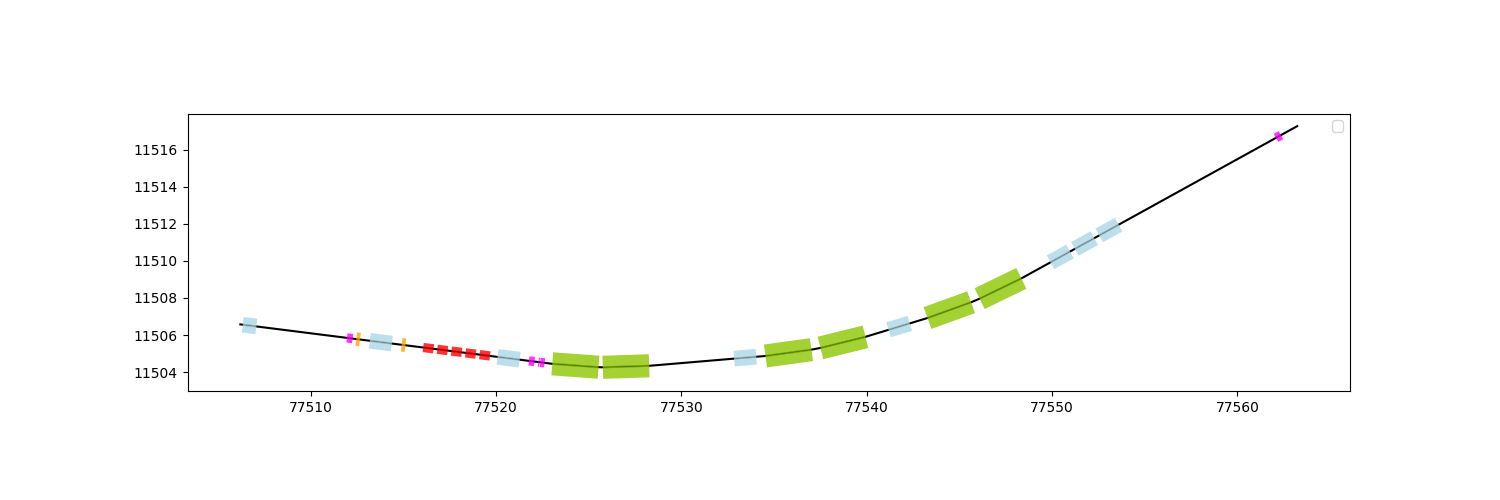

In [8]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

# Constants
RECTANGLE_WIDTH = 0.5  # Width of the rectangle in meters

# Update the plot
fig, ax = plt.subplots(figsize=(15,5))

# Plot the x, y coordinates
ax.plot(df_survey_f61t12_translated['x_rot'], df_survey_f61t12_translated['y_rot'], color='k',)

plot_magnets(df_survey_f61t12_translated, 'x_rot', 'y_rot', ax)

ax.legend()
ax.set_aspect('equal')

# ax.set_xlim(77520, 77550)
# ax.set_ylim(11506, 11515)

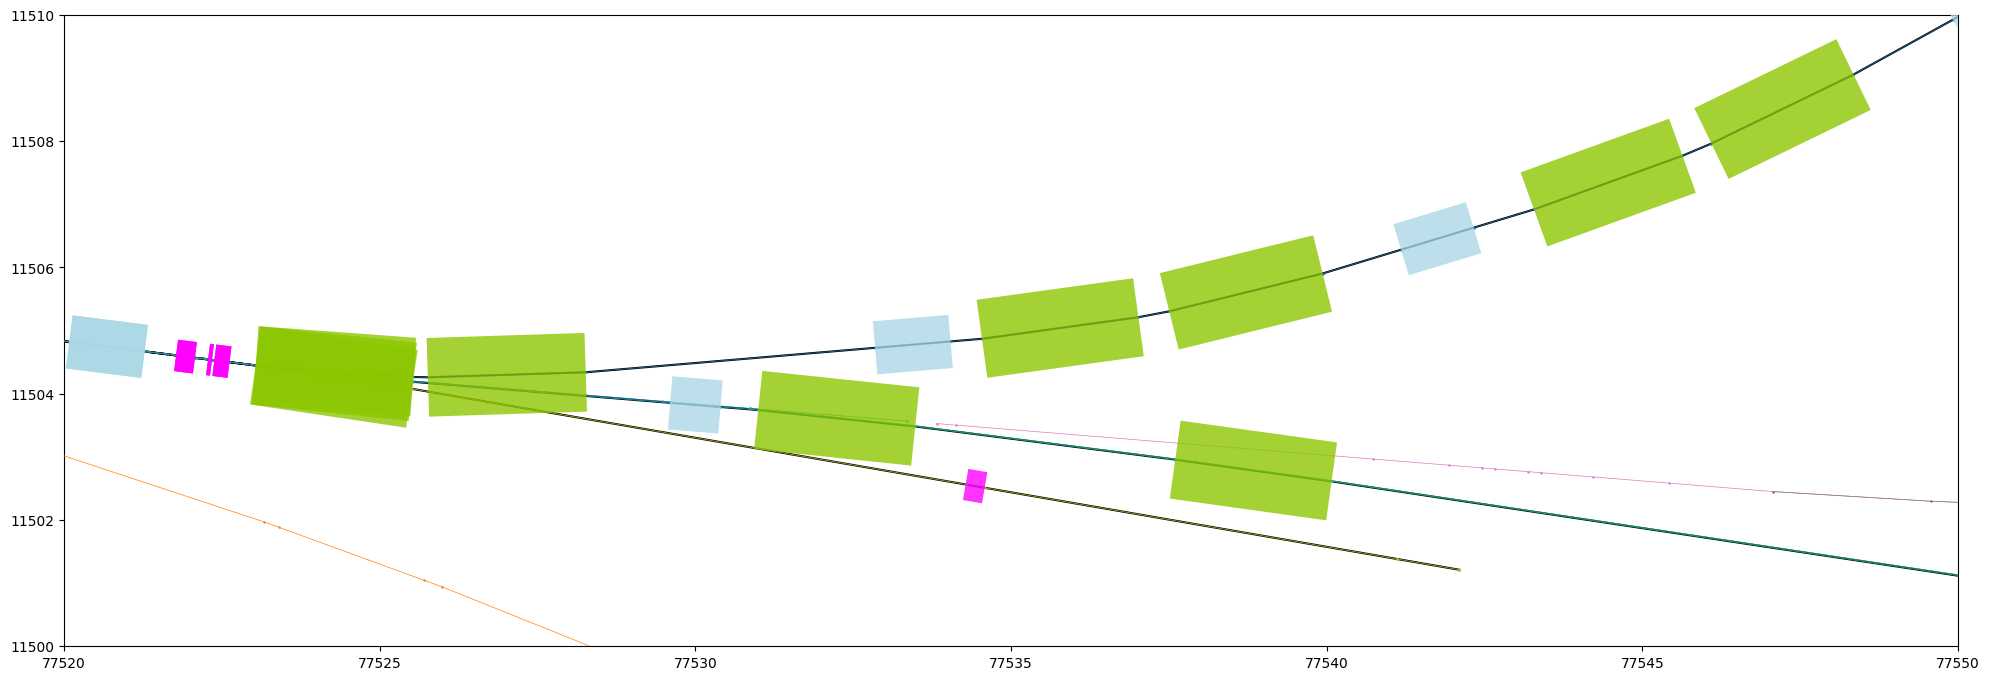

In [15]:
%matplotlib inline

survey_f61t12 = t12(p, exn, eyn, betx0, bety0, alfx0, alfy0, Dx0, Dy0, Dpx0, Dpy0)
df_survey_f61t12_translated = translate_rotate(survey_f61t12)

fig, ax = plt.subplots(figsize=(20,10), tight_layout=True)

for df in [df_f61, df_pr, df_t08, df_t09, df_t10, df_t11, df_f62, df_f63]:
    ax.plot(x_change_ref + df.x, y_change_ref + df.y, marker="+",zorder=99, markersize=2, linewidth=0.5)

for df in [df_survey_f61d_translated, df_survey_f61t8_translated, df_survey_f61t12_translated]:
    ax.plot(df.x_rot, df.y_rot, marker="+",zorder=99, markersize=2, linewidth=0.5)

for df in [df_survey_f61d_translated, df_survey_f61t8_translated, df_survey_f61t12_translated]:
    ax.plot(df['x_rot'], df['y_rot'], color='k')
    plot_magnets(df, 'x_rot', 'y_rot', ax)

xmin = 77520
xmax = 77550
ymin = 11500
ymax = 11510

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_aspect("equal")

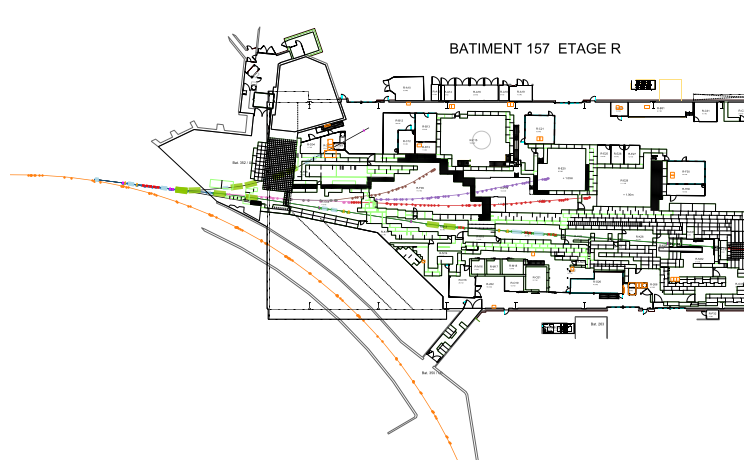

No such comm: e4b18f2dad7c4db888238c42ca26d15d


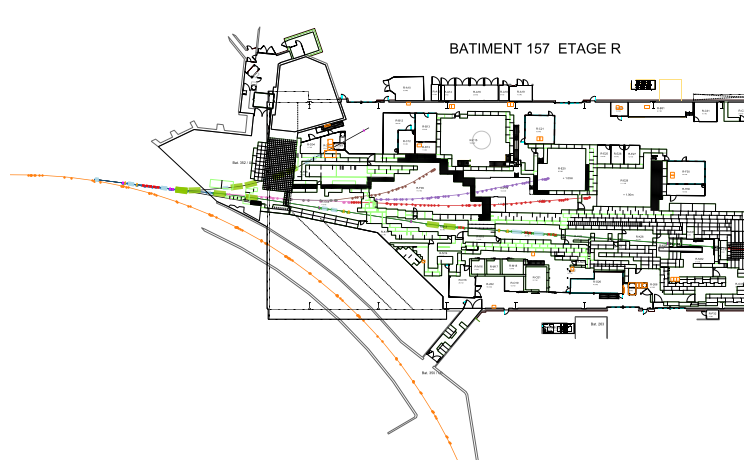

In [10]:
survey_f61t12 = t12(p, exn, eyn, betx0, bety0, alfx0, alfy0, Dx0, Dy0, Dpx0, Dpy0)
df_survey_f61t12_translated = translate_rotate(survey_f61t12)

fig, ax = plt.subplots(figsize=(50,10), tight_layout=True)
doc, auditor = recover.readfile('157_R.dxf')
ctx = RenderContext(doc)
out = MatplotlibBackend(ax)

from ezdxf.addons.drawing.config import Configuration, BackgroundPolicy
config = Configuration().with_changes(background_policy=BackgroundPolicy.CUSTOM, custom_bg_color="#ffffff00", lineweight_scaling=1)

frontend = Frontend(ctx, out, config=config)
frontend.draw_layout(doc.modelspace(), finalize=True)

for df in [df_f61, df_pr, df_t08, df_t09, df_t10, df_t11, df_f62, df_f63]:
    ax.plot(x_change_ref + df.x, y_change_ref + df.y, marker="+",zorder=99, markersize=2, linewidth=0.5)

for df in [df_survey_f61d_translated, df_survey_f61t8_translated, df_survey_f61t12_translated]:
    ax.plot(df['x_rot'], df['y_rot'], color='k', lw=0.5)
    plot_magnets(df, 'x_rot', 'y_rot', ax)

xmin = 77490
xmax = 77640
ymin = 11490
ymax = 11500

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

ax.set_aspect("equal")
fig.savefig('East_Area_combined_survey.png', dpi=800)

# Analysis of the line

In [11]:
from madxtools.plot_tool import *
def plot_graph(twiss, ex, sige, ey, fontsize=16, figsize=(10,6), height_ratios=[1,3,3,3,3]):
    
    fig, ax = plt.subplots(5,1, figsize=figsize, tight_layout=True, sharex=True, height_ratios=height_ratios)
    
    draw_synoptic(ax[0], twiss)
    
    ax[1].plot(twiss['s'], beam_size(twiss['betx'], twiss['dx'], ex, sige, 1)+twiss.x, alpha=1.0, color ="b", zorder=0)
    ax[1].plot(twiss['s'], -beam_size(twiss['betx'], twiss['dx'], ex, sige, 1)+twiss.x, alpha=1.0, color ="b", zorder=0)
    ax[1].set_xlim(0,twiss.s[-1])
    
    ax[2].plot(twiss['s'], beam_size(twiss['bety'], twiss['dy'], ey, sige, 1)+twiss.y, alpha=1.0, color ="r", zorder=0)
    ax[2].plot(twiss['s'], -beam_size(twiss['bety'], twiss['dy'], ey, sige, 1)+twiss.y, alpha=1.0, color ="r", zorder=0)
    ax[2].set_xlim(0,twiss.s[-1])
    
    ax[1].grid()
    ax[1].set_ylim(-0.12, 0.12)
    ax[1].set_ylabel(r"$\sigma_{H}$ [m]", fontsize=fontsize)
    
    ax[2].grid()
    ax[2].set_ylim(-0.12, 0.12)
    ax[2].set_ylabel(r"$\sigma_{V}$ [m]", fontsize=fontsize)
    
    ax[3].plot(twiss.s, twiss.betx, alpha=1.0, color ="darkblue", zorder=0, label="betx")
    ax[3].plot(twiss.s, twiss.bety, alpha=1.0, color ="darkred", zorder=0, label="bety")
    ax[3].set_xlim(0,twiss.s[-1])
    
    ax[3].legend()
    ax[3].set_ylim(0, 200)
    ax[3].grid()
    ax[3].set_ylabel(r"$\beta$ [m]", fontsize=fontsize)
    
    ax[4].plot(twiss.s, twiss.dx, alpha=1.0, color ="darkblue", zorder=0, label="dx")
    ax[4].plot(twiss.s, twiss.dy, alpha=1.0, color ="darkred", zorder=0, label="dy")
    ax[4].set_xlim(0,twiss.s[-1])
    
    ax[4].legend()
    # ax[4].set_ylim(0, 200)
    ax[4].grid()
    ax[4].set_ylabel(r"$\d$ [m]", fontsize=fontsize)

    draw_aperture_circle(ax[1], twiss, "aper_1")
    draw_aperture_circle(ax[2], twiss, "aper_1")
    draw_aperture_rectangle(ax[1], twiss, "aper_1")
    draw_aperture_rectangle(ax[2], twiss, "aper_2")
    draw_aperture_racetrackH(ax[1], twiss, "aper_1", "aper_2", "aper_3", "aper_4")
    draw_aperture_racetrackV(ax[2], twiss, "aper_1", "aper_2", "aper_3", "aper_4")

    plt.show()


/Users/eliottjohnson/git_repos/t12/venv/lib/python3.10/site-packages/madxtools/plot_tool.py:83: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.set_xlim(0,twiss.s[-1])
/var/folders/8q/l42hhsl13fxd0py0_2dw6k900000gn/T/ipykernel_15058/3828358199.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax[1].set_xlim(0,twiss.s[-1])
/var/folders/8q/l42hhsl13fxd0py0_2dw6k900000gn/T/ipykernel_15058/3828358199.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, u

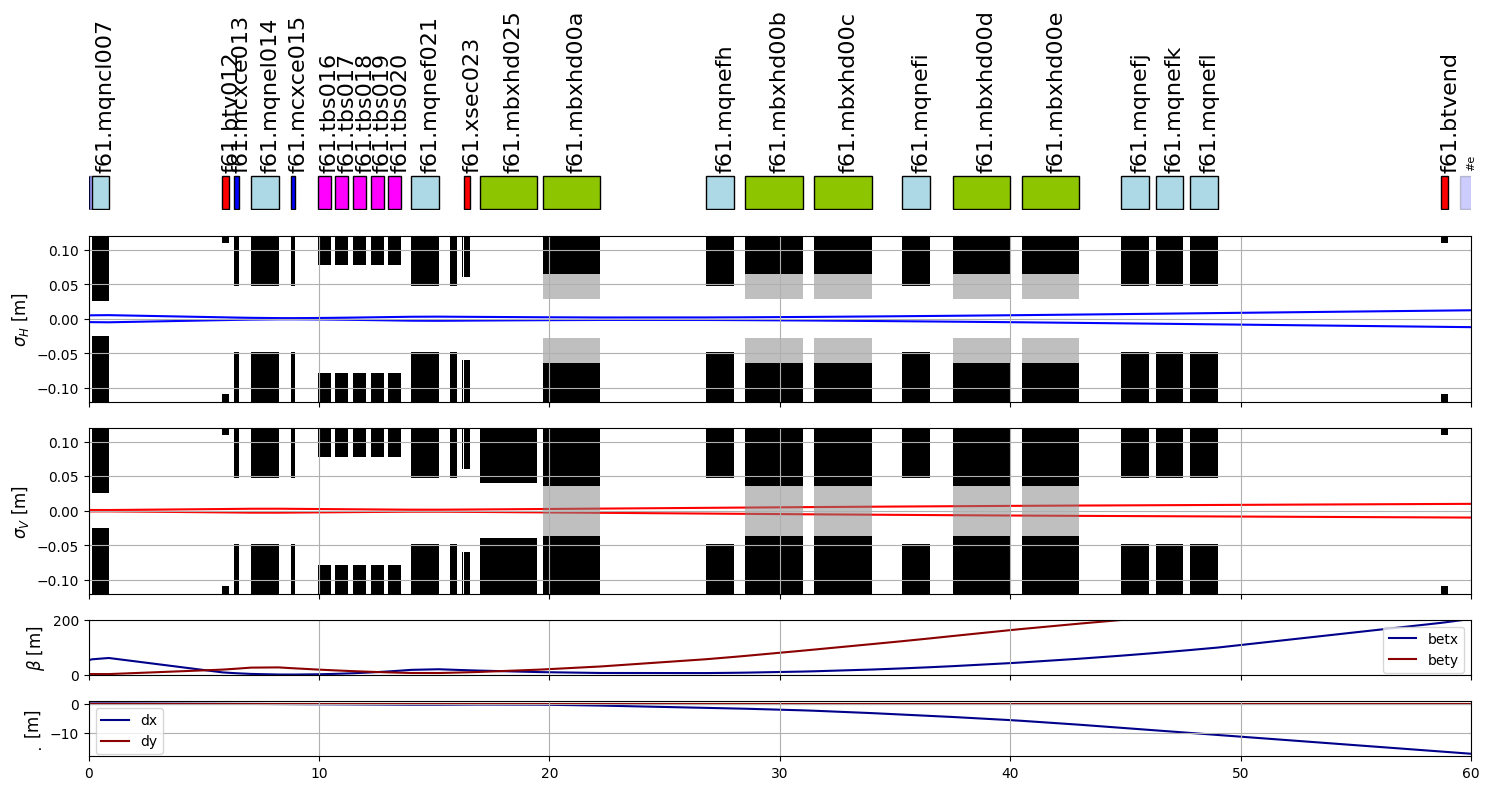

In [12]:
#################################### Initialize MADX ####################################
with open('tempfile', 'w') as f:
    madx = Madx(stdout=f,stderr=f)
    madx.option(verbose=True, debug=False, echo=True, warn=True, twiss_print=False)

madx.call("f61t12_early.seq")
madx.call("f61t12_early.str")

madx.command.beam(particle='PROTON',pc=p,exn=exn,eyn=eyn)
madx.input('BRHO      := BEAM->PC * 3.3356;')

madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APERTYPE,APER_1,APER_2,APER_3,APER_4,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')
# madx.input('SELECT, FLAG=aperture, COLUMN=apertype;')

madx.input("kQFN1 = "+str(0.4797)+";")
madx.input("kQDN2 = "+str(-0.173)+";")
madx.input("kQFN3 = "+str(0.1986)+";")

# madx.input("kQFN4 = "+str(0.4797)+";")
# madx.input("kQDN5 = "+str(-0.173)+";")
# madx.input("kQFN6 = "+str(0.1986)+";")
# madx.input("kQFN7 = "+str(0.4797)+";")
# madx.input("kQDN8 = "+str(-0.173)+";")

madx.use(sequence="f61t12")
twiss_f61t12 = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=Dx0, Dy=Dy0, Dpx=Dpx0, Dpy=Dpy0).dframe()

plot_graph(twiss_f61t12, ex, sige, ey, fontsize=12, figsize=(15,8), height_ratios=[1,3,3,1,1])

In [13]:
# Smallest beam size
import scipy.optimize as optimize

instrument_focal_point = "f61.btvend"

def f_focal_at_location(params):
    k_QFN1, k_QDN2, k_QFN3, k_QFN4, k_QFN5, k_QFN6, k_QFN7, k_QFN8 = params
    print(params)
    #################################### Initialize MADX ####################################
    with open('tempfile', 'w') as f:
        madx = Madx(stdout=f,stderr=f)
        madx.option(verbose=True, debug=False, echo=True, warn=True, twiss_print=False)

    madx.call("f61t12_early.seq")
    madx.call("f61t12_early.str")


    madx.command.beam(particle='PROTON',pc=p,exn=exn,eyn=eyn)
    madx.input('BRHO      := BEAM->PC * 3.3356;')

    madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APERTYPE,APER_1,APER_2,APER_3,APER_4,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')
    # madx.input('SELECT, FLAG=aperture, COLUMN=apertype;')


    madx.input("kQFN1 = "+str(k_QFN1)+";")
    madx.input("kQDN2 = "+str(k_QDN2)+";")
    madx.input("kQFN3 = "+str(k_QFN3)+";")
    madx.input("kQFN4 = "+str(k_QFN4)+";")
    madx.input("kQFN5 = "+str(k_QFN5)+";")
    madx.input("kQFN6 = "+str(k_QFN6)+";")
    madx.input("kQFN7 = "+str(k_QFN7)+";")
    madx.input("kQFN8 = "+str(k_QFN8)+";")

    madx.use(sequence="f61t12")
    twiss = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=Dx0, Dy=Dy0, Dpx=Dpx0, Dpy=Dpy0).dframe()

   
    penality = 0
    if ( any(val < 0 for val in twiss.loc[twiss.aper_1 != 0].aper_1 - beam_size(twiss.loc[twiss.aper_1 != 0]['betx'], twiss.loc[twiss.aper_1 != 0]['dx'], ex, sige, 2)) == True): # Only do the check were you have aperture data
        print ("Touching aperture H")
        penality = 1e2
    if ( any(val < 0 for val in twiss.loc[twiss.aper_2 != 0].aper_2 - beam_size(twiss.loc[twiss.aper_2 != 0]['bety'], twiss.loc[twiss.aper_2 != 0]['dy'], ey, sige, 2)) == True):
        print ("Touching aperture V")
        penality = 1e2
        

    x_beam_size = beam_size(twiss['betx'], twiss['dx'], ex, sige, 1).sum()
    y_beam_size = beam_size(twiss['bety'], twiss['dy'], ey, sige, 1).sum()

    dx =  np.abs(twiss['dx']).sum()

    print(f"x_beam_size = {round(x_beam_size,3)}")
    print(f"y_beam_size = {round(x_beam_size,3)}")
    print(f"dx = {round(dx,3)}")
    print(f"penalty = {round(penality,3)}")

    objective = x_beam_size**2*1000 + y_beam_size**2*1000 + penality + dx
    print (f"OJECTIVE = {round(objective,3)}")
    return objective

# initial_guess = [0.44458182, -0.1527928, 0.04666728, 0.17853134, -0.15145882, 0.45985371, -0.47777276, -0.44443377]
initial_guess = [0.44458182, -0.1527928, 0.04666728, -0.15145882, 0.0, 0.0, 0.0, 0.0]
result = optimize.minimize(f_focal_at_location, initial_guess, bounds = [(0,0.53823),(-0.221974,0.0),(0,0.215518), (-0.5,0.5), (-0.5,0.5), (-0.5,0.5), (-0.5,0.5), (-0.5,0.5)], method="Nelder-Mead", options={"maxiter": 10000}) # options={"maxiter": 10}
if result.success:
    result.x
    print(result)
else:
    raise ValueError(result.message)

[ 0.44458182 -0.1527928   0.04666728 -0.15145882  0.          0.
  0.          0.        ]
Touching aperture H
x_beam_size = 0.49
y_beam_size = 0.49
dx = 337.134
penalty = 100.0
OJECTIVE = 699.487
[ 0.46681091 -0.1527928   0.04666728 -0.15145882  0.          0.
  0.          0.        ]
Touching aperture H
x_beam_size = 0.712
y_beam_size = 0.712
dx = 345.571
penalty = 100.0
OJECTIVE = 975.38
[ 0.44458182 -0.16043244  0.04666728 -0.15145882  0.          0.
  0.          0.        ]
Touching aperture H
x_beam_size = 0.482
y_beam_size = 0.482
dx = 337.648
penalty = 100.0
OJECTIVE = 689.4
[ 0.44458182 -0.1527928   0.04900064 -0.15145882  0.          0.
  0.          0.        ]
Touching aperture H
x_beam_size = 0.486
y_beam_size = 0.486
dx = 336.173
penalty = 100.0
OJECTIVE = 694.878
[ 0.44458182 -0.1527928   0.04666728 -0.15903176  0.          0.
  0.          0.        ]
Touching aperture H
x_beam_size = 0.502
y_beam_size = 0.502
dx = 343.879
penalty = 100.0
OJECTIVE = 719.71
[ 4.4458182

KeyboardInterrupt: 

In [18]:
result.x

array([ 0.43519621, -0.12675402,  0.00158563,  0.23208246, -0.12734295,
        0.04364985,  0.11894956, -0.02977307])

/var/folders/8q/l42hhsl13fxd0py0_2dw6k900000gn/T/ipykernel_12603/3828358199.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax[1].set_xlim(0,twiss.s[-1])
/var/folders/8q/l42hhsl13fxd0py0_2dw6k900000gn/T/ipykernel_12603/3828358199.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax[2].set_xlim(0,twiss.s[-1])
/var/folders/8q/l42hhsl13fxd0py0_2dw6k900000gn/T/ipykernel_12603/3828358199.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.il

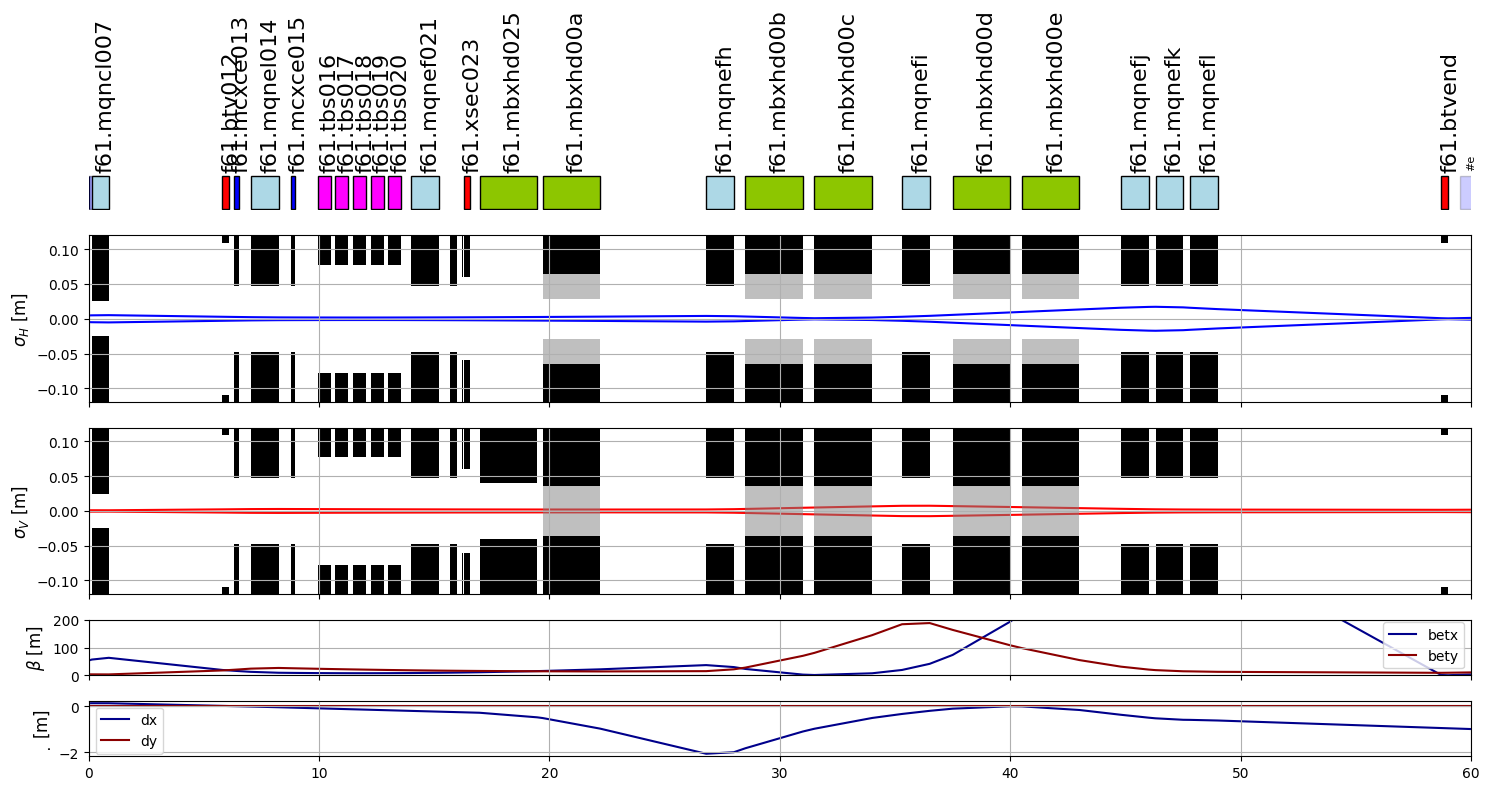

In [19]:
#################################### Initialize MADX ####################################
with open('tempfile', 'w') as f:
    madx = Madx(stdout=f,stderr=f)
    madx.option(verbose=True, debug=False, echo=True, warn=True, twiss_print=False)

madx.call("f61t12_early.seq")
madx.call("f61t12_early.str")

madx.command.beam(particle='PROTON',pc=p,exn=exn,eyn=eyn)
madx.input('BRHO      := BEAM->PC * 3.3356;')

madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APERTYPE,APER_1,APER_2,APER_3,APER_4,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')

madx.input("kQFN1 = "+str(result.x[0])+";")
madx.input("kQDN2 = "+str(result.x[1])+";")
madx.input("kQFN3 = "+str(result.x[2])+";")

madx.input("kQFN4 = "+str(result.x[3])+";")
madx.input("kQFN5 = "+str(result.x[4])+";")
madx.input("kQFN6 = "+str(result.x[5])+";")
madx.input("kQFN7 = "+str(result.x[6])+";")
madx.input("kQFN8 = "+str(result.x[7])+";")

madx.use(sequence="f61t12")
twiss_f61t12 = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=Dx0, Dy=Dy0, Dpx=Dpx0, Dpy=Dpy0).dframe()
plot_graph(twiss_f61t12, ex, sige, ey, fontsize=12, figsize=(15,8), height_ratios=[1,3,3,1,1])